In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu' 

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = MobileNetV2()
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

In [5]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda:2':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [13]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list = []
accuracy_list=[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=150 and epoch != 0:
            param_group['lr'] = lr * 0.98
            
        print(param_group['lr'])

In [14]:
for epoch in range(0, 150):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.7916666666666666
Current benign train loss: 0.5994411110877991

Current batch: 100
Current benign train accuracy: 0.7708333333333334
Current benign train loss: 0.6851136684417725

Current batch: 200
Current benign train accuracy: 0.7604166666666666
Current benign train loss: 0.5846101641654968

Current batch: 300
Current benign train accuracy: 0.8125
Current benign train loss: 0.5793777704238892

Current batch: 400
Current benign train accuracy: 0.8125
Current benign train loss: 0.5571503639221191

Current batch: 500
Current benign train accuracy: 0.71875
Current benign train loss: 0.7897974848747253

Total benign train accuarcy: 77.466
Total benign train loss: 336.71338844299316

[ Test epoch: 0 ]

Test accuarcy: 77.16
Test average loss: 0.007147360894083977
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.75
Current benign train loss: 0.6463717818260193

Current batc


Current batch: 200
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.24572546780109406

Current batch: 300
Current benign train accuracy: 0.84375
Current benign train loss: 0.4235965311527252

Current batch: 400
Current benign train accuracy: 0.84375
Current benign train loss: 0.37150195240974426

Current batch: 500
Current benign train accuracy: 0.8541666666666666
Current benign train loss: 0.41749536991119385

Total benign train accuarcy: 88.32
Total benign train loss: 175.08711531758308

[ Test epoch: 9 ]

Test accuarcy: 87.11
Test average loss: 0.00421521302908659
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.875
Current benign train loss: 0.38022223114967346

Current batch: 100
Current benign train accuracy: 0.8541666666666666
Current benign train loss: 0.4101130962371826

Current batch: 200
Current benign train accuracy: 0.8541666666666666
Current benign train loss: 0.41146978735923767

Curr


Current batch: 400
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.2405022233724594

Current batch: 500
Current benign train accuracy: 0.9375
Current benign train loss: 0.15407384932041168

Total benign train accuarcy: 92.098
Total benign train loss: 115.84752409905195

[ Test epoch: 18 ]

Test accuarcy: 88.37
Test average loss: 0.0037941769614815712
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9375
Current benign train loss: 0.2040964812040329

Current batch: 100
Current benign train accuracy: 0.90625
Current benign train loss: 0.23088891804218292

Current batch: 200
Current benign train accuracy: 0.90625
Current benign train loss: 0.21016333997249603

Current batch: 300
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.26186686754226685

Current batch: 400
Current benign train accuracy: 0.90625
Current benign train loss: 0.2082231193780899

Current batch: 500
Curr


Total benign train accuarcy: 94.456
Total benign train loss: 82.5999387409538

[ Test epoch: 27 ]

Test accuarcy: 89.65
Test average loss: 0.0035725535579025744
Model Saved!
0.02555892791775266

[ Train epoch: 28 ]

Current batch: 0
Current benign train accuracy: 0.9375
Current benign train loss: 0.12966492772102356

Current batch: 100
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.36640694737434387

Current batch: 200
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.15393789112567902

Current batch: 300
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.15407820045948029

Current batch: 400
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.10627421736717224

Current batch: 500
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.14830122888088226

Total benign train accuarcy: 94.726
Total benign train loss: 79.4878012649715

[ Test epoch: 28


Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.10315918922424316

Current batch: 100
Current benign train accuracy: 0.96875
Current benign train loss: 0.08907955139875412

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.09791142493486404

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.09197509288787842

Current batch: 400
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.11946254968643188

Current batch: 500
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.17880673706531525

Total benign train accuarcy: 96.33
Total benign train loss: 53.974509679712355

[ Test epoch: 37 ]

Test accuarcy: 89.8
Test average loss: 0.0039580545656383035
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.11971175670623779

Current bat


Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.07613439112901688

Current batch: 300
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.0896991416811943

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.07607883960008621

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.03956752270460129

Total benign train accuarcy: 97.344
Total benign train loss: 38.75413051666692

[ Test epoch: 46 ]

Test accuarcy: 90.23
Test average loss: 0.004120476227253676
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.07732325047254562

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.059025123715400696

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.102185


Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.0702233836054802

Current batch: 400
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.13589757680892944

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.03813358023762703

Total benign train accuarcy: 98.004
Total benign train loss: 28.973197107203305

[ Test epoch: 55 ]

Test accuarcy: 91.11
Test average loss: 0.0040965871058404445
Model Saved!
0.01451686214010837

[ Train epoch: 56 ]

Current batch: 0
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.11307605355978012

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.02926436811685562

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.028580976650118828

Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.062620528


Current batch: 500
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.0942264199256897

Total benign train accuarcy: 98.738
Total benign train loss: 18.66335031040944

[ Test epoch: 64 ]

Test accuarcy: 91.06
Test average loss: 0.00438095081821084
Model Saved!
0.012103401322467249

[ Train epoch: 65 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0042295437306165695

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.015659110620617867

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.008144238032400608

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.04272519424557686

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.016180826351046562

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.04680236056447029

Total benign train acc


Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.04685394465923309

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.06374365836381912

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.027760891243815422

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00931574683636427

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0043543558567762375

Total benign train accuarcy: 99.272
Total benign train loss: 11.193892689363565

[ Test epoch: 74 ]

Test accuarcy: 91.7
Test average loss: 0.004496869300305843
Model Saved!
0.009889360091434759

[ Train epoch: 75 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.013799436390399933

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.021024765446782112

Curre


Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.01731792464852333

Total benign train accuarcy: 99.454
Total benign train loss: 7.969180293905083

[ Test epoch: 83 ]

Test accuarcy: 91.76
Test average loss: 0.004663613673299551
Model Saved!
0.008245231845132941

[ Train epoch: 84 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.008065938018262386

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.028194352984428406

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00347808375954628

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.006747792009264231

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.02085311897099018

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.07376326620578766

Total b


Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.022937847301363945

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007569491281174123

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.008499237708747387

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.0171156357973814

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.05148015543818474

Total benign train accuarcy: 99.684
Total benign train loss: 5.194018018082716

[ Test epoch: 93 ]

Test accuarcy: 92.0
Test average loss: 0.004823242438584566
Model Saved!
0.006736954727141358

[ Train epoch: 94 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009312839829362929

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.002975914627313614

Current batch: 200
C


Total benign train accuarcy: 99.744
Total benign train loss: 4.0819605120050255

[ Test epoch: 102 ]

Test accuarcy: 91.91
Test average loss: 0.004789640228636563
Model Saved!
0.00561692092732624

[ Train epoch: 103 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0021982600446790457

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0006016060360707343

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.001737138838507235

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00036216495209373534

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0009504581685177982

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00038419660995714366

Total benign train accuarcy: 99.818
Total benign train loss: 3.1640615621436154

[ Test epoch: 103 ]

Test accuarcy: 91.99
Test average loss: 0.0047568449527


Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.028421292081475258

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0014678057050332427

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0013138880021870136

Total benign train accuarcy: 99.816
Total benign train loss: 3.044656044578005

[ Test epoch: 112 ]

Test accuarcy: 92.23
Test average loss: 0.005079602562636137
Model Saved!
0.004589433348155853

[ Train epoch: 113 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009759750100784004

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0067822798155248165

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0020974238868802786

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.005108620040118694

Current batch: 400
Current benign train a


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0006640367791987956

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0013759512221440673

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007029273547232151

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0001886035461211577

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0004943636595271528

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0009098207228817046

Total benign train accuarcy: 99.91
Total benign train loss: 1.6866145821477403

[ Test epoch: 122 ]

Test accuarcy: 91.87
Test average loss: 0.004982683895528316
Model Saved!
0.0037499011878010143

[ Train epoch: 123 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.002070000162348151

Current batch: 100
Current benign train accuracy: 1.0
Cu


Total benign train accuarcy: 99.902
Total benign train loss: 1.7466491548220802

[ Test epoch: 131 ]

Test accuarcy: 92.14
Test average loss: 0.0049902642597444355
Model Saved!
0.003126471723538286

[ Train epoch: 132 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.007022250443696976

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0005514013464562595

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 5.0347342039458454e-05

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 5.8463934692554176e-05

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0012007096083834767

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0005163908354006708

Total benign train accuarcy: 99.896
Total benign train loss: 1.7110426323961292

[ Test epoch: 132 ]

Test accuarcy: 92.23
Test average loss: 0.00491732466


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0012675182661041617

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0002873469493351877

Total benign train accuarcy: 99.928
Total benign train loss: 1.3281545714307867

[ Test epoch: 141 ]

Test accuarcy: 92.08
Test average loss: 0.004933653945475817
Model Saved!
0.0025545550268059737

[ Train epoch: 142 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009676226763986051

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00652665039524436

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0017330331029370427

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.002295485930517316

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0010096613550558686

Current batch: 500
Current benign train accuracy: 1.0
C

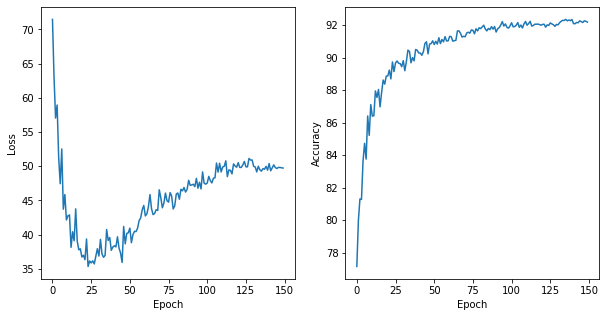

In [15]:
epochs = np.arange(0,150)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.plot(epochs,loss_list) 
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list) 
plt.show()